<h4>Required Libs</h4>

In [26]:
import pandas as pd 
import numpy as np
import random
from collections import Counter
from datetime import date, timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error , r2_score ,accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import joblib
import json

In [27]:
def random_dates(start, end, n=541909):

    start_u = start.value//10**9
    end_u = end.value//10**9
    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')


start = pd.to_datetime('2022-01-01')

end = pd.to_datetime('2023-05-12')

df = pd.read_csv('raw_data.csv',encoding = 'unicode_escape')

df['InvoiceDate'] = random_dates(start, end)

df.to_csv('raw_data.csv')

<h4>Data Preprocessing</h4>

In [28]:
# Reading CSV
df = pd.read_csv('raw_data.csv',encoding = 'unicode_escape')
# Replacing empty CustomerID with nan
df['CustomerID'].replace('', np.nan, inplace=True)
# Replacing empty Description with nan
df['Description'].replace('', np.nan, inplace=True)
# droping all rows with NA
df.dropna()
# formatting only dates from date time from Invoice dates
df['InvoiceDate'] = df['InvoiceDate'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
# dropping not required columns
df = df.drop(columns=['Unnamed: 0.1','Unnamed: 0'])
# Displaying df
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,discount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-06-22,2.55,17850.0,United Kingdom,0.7
1,536365,71053,WHITE METAL LANTERN,6,2022-06-07,3.39,17850.0,United Kingdom,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-11-30,2.75,17850.0,United Kingdom,0.5
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-06-18,3.39,17850.0,United Kingdom,0.8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-08-03,3.39,17850.0,United Kingdom,0.9


<h4>Data informations</h4>

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   discount     541909 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


<h4>Data Formatting / Feature Engineering methods</h4>

In [50]:
## Method to get the dataframe groupedBy customerId and format the data
def formatData(df):
    
  customer_eligibility_data = [] 
 
  for name, group in df:
    invoiceDates = list(set(group['InvoiceDate']))
    purchase_streek = 0

    for prevDate, currentDate in zip(invoiceDates, invoiceDates[1:]):
       invoice_date_diff = currentDate - prevDate 
       if(invoice_date_diff.days < 30):
            purchase_streek += 1

    purchase_total_amount = int(abs(sum(group['UnitPrice'])))


    customer_eligibility_data.append({ 
        "customerId" : name, 
        "description" : list(set(group['Description']))[0],
        "purchase_by_invoice" : len(set(group['InvoiceNo'])), 
        "purchase_total_amount" : purchase_total_amount, # add int
        "purchase_streek" : purchase_streek,
        "next_streek_purchase_amount" : (1 + purchase_streek) * 100,
        "remaining_amount" : abs(((1+purchase_streek) * 100) - purchase_total_amount),
        "is_eligible_customer" : 1 if (purchase_streek > 0 and int(abs(sum(group['UnitPrice'])) > 150)) else 0,
        "offer_eligibility" : sum(group['discount']) if(int(abs(sum(group['UnitPrice']))) < 150 and sum(group['discount']) > 10) else (purchase_streek * 2)
    })

  customer_eligibility_data += json.loads(pd.read_csv('combiner_data.csv').to_json(orient="records"))
  
  col = ['customerId','description','purchase_by_invoice','purchase_total_amount',
         'purchase_streek','next_streek_purchase_amount','remaining_amount','is_eligible_customer','offer_eligibility'
        ]

  df = pd.DataFrame(columns=col, data=customer_eligibility_data)

  df.to_csv('formatted_data.csv')
    
  return df

def model_accuracy(classifier_name, x_test, x_train, y_test, y_pred, model):
    print(f"\n============================= {classifier_name} ==============================\n")
    print(f"Mean Absolute Error of {classifier_name}:", round(mean_absolute_error(y_test, y_pred), 4))
    print(f"Mean Squared Error of {classifier_name}:", round(mean_squared_error(y_test, y_pred), 4))
    print(f"Root Mean Squared Error of {classifier_name}:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))
    print(f"(R^2) Score of {classifier_name}:", round(r2_score(y_test, y_pred), 4))
    print(f'Test Score : {model.score(x_test, y_pred) * 100:.2f}% using Random Tree Regressor.')
  

<h4>Customer Average Buying Frequency</h4>

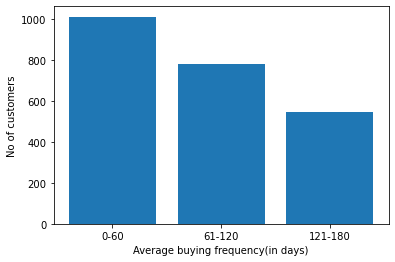

In [31]:
df_grouped_by_customer_id = df.groupby('CustomerID')
time_range_dict = { "0-60" : 0, "61-120" : 0, "121-180" : 0 }
average_invoice_date_group = []

for name, group in df_grouped_by_customer_id:
    invoiceDates = list(set(group['InvoiceDate']))
    sorted_dates = sorted(datetime.strptime(str(d), '%Y-%m-%d') for d in invoiceDates)
    time_difference = timedelta(0)
    counter = 0
    for i in range(1, len(sorted_dates), 1):
      counter += 1
      time_difference += sorted_dates[i] - sorted_dates[i-1]
      
    if(counter > 0):
     average_invoice_date_group.append((time_difference / counter).days)

for days in Counter(average_invoice_date_group).keys():
  if(days > 0 and days < 60):
    time_range_dict['0-60'] += average_invoice_date_group[days]
  elif(days > 61 and days < 120):
    time_range_dict['61-120'] += average_invoice_date_group[days]
  elif(days > 121 and days < 180):
    time_range_dict['121-180'] += average_invoice_date_group[days]


plt.bar(time_range_dict.keys(),time_range_dict.values())

plt.xlabel('Average buying frequency(in days)')
plt.ylabel('No of customers')
plt.show() 


   

In [38]:
df_grouped_by_customer_id = df.groupby('CustomerID')

df_purchase_count_based_offer_eligibity = formatData(df_grouped_by_customer_id)

display(df_purchase_count_based_offer_eligibity)

,customerId,description,purchase_by_invoice,purchase_total_amount,purchase_streek,next_streek_purchase_amount,remaining_amount,is_eligible_customer,offer_eligibility
0,12346.0,MEDIUM CERAMIC TOP STORAGE JAR,2,2,1,200,198,0,2.0
1,12347.0,ALARM CLOCK BAKELIKE GREEN,7,481,82,8300,7819,1,164.0
2,12348.0,DOUGHNUT LIP GLOSS,4,178,15,1600,1422,1,30.0
3,12349.0,DOORMAT RED RETROSPOT,1,605,33,3400,2795,1,66.0
4,12350.0,BATHROOM METAL SIGN,1,65,8,900,835,0,16.0
...,...,...,...,...,...,...,...,...,...
14372,11001.0,DOORMAT NEW ENGLAND,4,959,18,1900,941,1,36.0
14373,11002.0,JAM MAKING SET WITH JARS,3,290,3,400,110,1,6.0
14374,11003.0,RED COAT RACK PARIS FASHION,7,1504,15,1600,96,1,30.0
14375,11004.0,YELLOW COAT RACK PARIS FASHION,2,995,18,1900,905,1,36.0


<h4>Model for offer eligibility prediction</h4>

In [51]:
feature_variables_model = df_purchase_count_based_offer_eligibity[['purchase_total_amount','purchase_streek','next_streek_purchase_amount']]
## offer_eligibility as target parameter
target_variables_model = df_purchase_count_based_offer_eligibity[['offer_eligibility']]
## Spliting dataset into training and test data with test data size as 0.4 and training data size as 0.6
x_train, x_test, y_train, y_test = train_test_split(feature_variables_model.values, target_variables_model.values, test_size=0.5, random_state=100)
## Standardizing input with standard scaler
offer_eligibility_scaler = StandardScaler()
## fit transform of training values
x_train = offer_eligibility_scaler.fit_transform(x_train)
## transform values of test values
x_test = offer_eligibility_scaler.transform(x_test)
## defining random forest classifier model
model = RandomForestRegressor(n_estimators=500, random_state=100, min_samples_split=5, min_samples_leaf=2, max_depth=15, bootstrap=True)
## fiting the model
model.fit(x_train, y_train)
## predict
y_pred = model.predict(x_test)
## Accuracy
model_accuracy("offer eligibility model accuracy", x_test, x_train, y_test, y_pred, model)
## saving scaler
joblib.dump(offer_eligibility_scaler, filename="offer_eligibility_scaler.bin")
## saving the offer eligibility scaler model 
joblib.dump(model, filename="offer_eligibility_model.joblib")

/var/folders/fn/_6v6kkfx5sg9tlf7lff7lpk00000gp/T/ipykernel_60270/2838292600.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)



============================= offer eligibility model accuracy ==============================

Mean Absolute Error of offer eligibility model accuracy: 0.5473
Mean Squared Error of offer eligibility model accuracy: 4.9137
Root Mean Squared Error of offer eligibility model accuracy: 2.2167
(R^2) Score of offer eligibility model accuracy: 0.9983
Test Score : 100.00% using Random Tree Regressor.


['offer_eligibility_model.joblib']

<h4>Model for Minimum spend prediction</h4>

In [18]:
feature_variables_model = df_purchase_count_based_offer_eligibity[['purchase_total_amount','next_streek_purchase_amount']]
## offer_eligibility as target parameter
target_variables_model = df_purchase_count_based_offer_eligibity[['remaining_amount']]
## Spliting dataset into training and test data with test data size as 0.4 and training data size as 0.6
x_train, x_test, y_train, y_test = train_test_split(feature_variables_model.values, target_variables_model.values, test_size=0.5, random_state=100)
## Standardizing input with standard scaler

'''
minimum_price_spend_scaler = StandardScaler()
## fit transform of training values
x_train = minimum_price_spend_scaler.fit_transform(x_train)
## transform values of test values
x_test = minimum_price_spend_scaler.transform(x_test)
'''

## defining random forest classifier model
model = RandomForestRegressor(n_estimators=500, random_state=100, min_samples_split=5, min_samples_leaf=2, max_depth=15, bootstrap=True)
## fiting the model
model.fit(x_train, y_train)
## predict
y_pred = model.predict(x_test)
## Accuracy
model_accuracy("Minimum spend model accuracy", x_test, x_train, y_test, y_pred, model)
## saving scaler
joblib.dump(minimum_price_spend_scaler, filename="minimum_price_spend_scaler.bin")
## saving the offer eligibility scaler model 
joblib.dump(model, filename="minimum_spend_model.joblib")

/var/folders/fn/_6v6kkfx5sg9tlf7lff7lpk00000gp/T/ipykernel_60270/1789696731.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)



============================= Minimum spend model accuracy ==============================

Mean Absolute Error of Minimum spend model accuracy: 14.9796
Mean Squared Error of Minimum spend model accuracy: 11794.7225
Root Mean Squared Error of Minimum spend model accuracy: 108.6035
(R^2) Score of Minimum spend model accuracy: 0.9983
Train Score of Minimum spend model accuracy: 98.19% and Test Score : 99.83% using Random Tree Regressor.


['minimum_spend_model.joblib']

<h4>Helper Method to process input to model</h4>

In [19]:
def formatInput(requestBody):
    purchase_streek = requestBody['purchase_streek']
    purchases = [purchase for purchase in requestBody['purchase_history'] if ((datetime.strptime(purchase['invoice_date'], "%Y-%m-%d") - datetime.strptime(requestBody['last_streek_date'], "%Y-%m-%d")).days < 30)]
    purchase_total_amount = 0
    for invoice in purchases:
       purchase_total_amount += invoice['purchase_amount']
    if(purchase_total_amount >= ((purchase_streek + 1)*100)):
        purchase_streek += 1
        purchase_total_amount = 0
    return { "purchase_total_amount" : purchase_total_amount, "purchase_streek" : purchase_streek, "next_streek_purchase_amount" : ((purchase_streek + 1)*100) }
    

In [22]:
requestBody = {
    "purchase_history" : [
        { "customer_id" : 123, "invoice_number" : 1000, "invoice_date" : "2023-05-01", "purchase_amount" : 100 },
        { "customer_id" : 123, "invoice_number" : 1001, "invoice_date" : "2023-05-03", "purchase_amount" : 10 },
        { "customer_id" : 123, "invoice_number" : 1002, "invoice_date" : "2023-05-05", "purchase_amount" : 20 },
        { "customer_id" : 123, "invoice_number" : 1003, "invoice_date" : "2023-05-07", "purchase_amount" : 40 },
    ],
    "last_streek_date" : "2023-04-27",
    "purchase_streek" : 4
}

## load scalers 
offer_eligibility_scaler = joblib.load('offer_eligibility_scaler.bin')
minimum_price_spend_scaler = joblib.load('minimum_price_spend_scaler.bin')

## load models
offer_eligibility_model = joblib.load('offer_eligibility_model.joblib')
minimum_price_spend_model = joblib.load('minimum_price_spend_scaler.bin')

offer_predictor = joblib.load('offer_eligibility_model.joblib')
minimum_spend_predictor = joblib.load('minimum_spend_model.joblib')

print("model input", formatInput(requestBody=requestBody))

print("\nOffer eligibility ",offer_predictor.predict(offer_eligibility_scaler.transform(pd.DataFrame(columns=['purchase_total_amount','purchase_streek',"next_streek_purchase_amount"], data=[formatInput(requestBody=requestBody)]))))
print("\nMinimum price spend ",minimum_spend_predictor.predict(pd.DataFrame(columns=["purchase_total_amount","next_streek_purchase_amount"], data=[formatInput(requestBody=requestBody)])))


model input {'purchase_total_amount': 170, 'purchase_streek': 4, 'next_streek_purchase_amount': 500}

Offer eligibility  [8.]

Minimum price spend  [328.66447302]


/Users/kramac538/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/kramac538/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
